# Mini Projet

#### Imports

In [235]:
import cv2 as cv
import numpy as np
import matplotlib.pylab as plt
import math
import random
import csv
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score

### Prétraitement

In [246]:
def binarisation(img):
    return cv.threshold(img, 127, 255, cv.THRESH_BINARY)[1]


def inversion(img):
    h, l = img.shape

    for i in range(h):
        for j in range(l):
            if img[i, j] == 0:
                img[i, j] = 255
            else:
                img[i, j] = 0

    return img


def resize(img: np.array, scale_percent: int):

    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)

    return cv.resize(img, (width, height))

### Extraction

#### Moment de Hu

In [247]:
def moment_ordre(img, p, q):
    h, l = img.shape
    mpq = 0
    for i in range(h):
        for j in range(l):
            mpq += (i**p) * (j**q) * img[i, j]

    return mpq

def moment_centraux(img, p, q):
    h, l = img.shape

    m00 = moment_ordre(img, 0, 0)
    m01 = moment_ordre(img, 0, 1)
    m10 = moment_ordre(img, 1, 0)

    x_bar = (m10 / m00)
    y_bar = (m01 / m00)

    mupq = 0

    for i in range(h):
        for j in range(l):
            mupq += ((i - x_bar)**p) * ((j - y_bar)**q) * img[i, j]

    return mupq

def alphapq(img, p, q):
    gama = ((p + q) / 2) + 1

    alpha = moment_centraux(img, p, q) / moment_centraux(img, 0, 0)**gama

    return alpha

def moment_hu(img):
    phi = np.zeros([7], dtype=np.float64)

    a20 = alphapq(img, 2, 0)
    a02 = alphapq(img, 0, 2)
    a11 = alphapq(img, 1, 1)
    a30 = alphapq(img, 3, 0)
    a12 = alphapq(img, 1, 2)
    a03 = alphapq(img, 0, 3)
    a21 = alphapq(img, 2, 1)

    phi[0] = a20 - a02
    phi[1] = (a20 - a02)**2 + 4*a11**2
    phi[2] = (a30 - a12)**2 + (3*a12 - a03)**2
    phi[3] = (a30 - a12)**2 + (a12 - a03)**2
    phi[4] = (a30 - 3*a12) * (a30 + a12) * ((a30 + a12)**2 - 3*(a21 + a03)**2) + (3*a21 - a03)*(a21 + a03)*(3*(a30+a12**2) - (a21 + a03)**2)
    phi[5] = (a20 - a02) * ((a30 + a12)**2 - (a21 + a30)**2) + 4*a11*(a30 + a12)*(a21 + a03)
    phi[6] = (3*a21 - a30) * (a30 + a12) * ((a30 + a12)**2 - 3*(a21 + a03)**2) + (3*a12 - a03) * (a21 + a03)*(3*(a30 + a12)**2 - (a21 + a03)**2)

    return phi

#### Moment de tchebichef

In [248]:
def squared_norm(n, N):
    return (math.factorial(N + n) / ((2 * n + 1) * math.factorial(N - n - 1)))

def pochhammer_symbol(a, k):
    s = 1
    if k >= 1:
        for i in range(k):
            s *= (a + i)
    return s

def polynomial(x, n, M):
    t1 = pochhammer_symbol(1 - M, n)
    t2 = math.sqrt(squared_norm(n, M))

    s = 0

    for i in range(n + 1):
        t3 = pochhammer_symbol(-n, i)
        t4 = pochhammer_symbol(-x, i)
        t5 = pochhammer_symbol(1 + n, i)
        t6 = (math.factorial(i))**2
        t7 = pochhammer_symbol(1 - M, i)

        s+= (t3 * t4 * t5) / (t6 * t7)
    
    return ((t1 / t2) * s)

def momentpq(img, n, m):
    M, N = img.shape

    tnm = 0

    for i in range(M):
        for j in range(N):
            tnm += (polynomial(i, n, M) * polynomial(j, m, M) * img[i, j])

    return tnm


def moment_tchebichef(img , order=3):
    moments = []

    for i in range(order + 1):
        for j in range(order + 1):
            if i + j <= order:
                moments.append(momentpq(img, i, j))

    return moments

### Lecture des images et les Fichiers CSV

In [249]:
def lecture_des_images(dataset_path, n_class, n_imgs):
    dataset = []

    for i in range(n_class):
        for j in range(1, n_imgs + 1):
            dataset.append(binarisation(
                cv.imread(f"{dataset_path}/{i}/{j}.png", 0)))

    return dataset

In [250]:
def csv_files_maker(dataset, n_class, n_imgs, percent_training, moment):

    training = int(n_imgs * percent_training)

    with open('training_' + moment.__name__ + '.csv', 'w') as file:
        writer = csv.writer(file)
        data = []
        index = 0

        for i in range(n_class):
            for j in range(training):
                data = [j, *moment(dataset[index + j]), i]
                writer.writerow(data)
            index += (n_imgs - 1)

    if percent_training != 1:
        
        with open('test_' + moment.__name__ + '.csv', 'w') as file:
            writer = csv.writer(file)
            data = []
            index = 0

            for i in range(n_class):
                for j in range(training, n_imgs):
                    data = [j, *moment(dataset[index + j]), i]
                    writer.writerow(data)
                index += (n_imgs - 1)


def read_csv_files(file_path):
    with open(file_path, 'r') as file:
        return np.loadtxt(file, delimiter=",", dtype=np.float128)

#### Dataset

In [251]:
dataset = lecture_des_images("./dataset", 10, 10)

# Moment de Hu

csv_files_maker(dataset, 10, 10, 0.8, moment_hu)

# Moment de Tchebichef

csv_files_maker(dataset, 10, 10, 0.8, moment_tchebichef)

### Classification

#### Mesures de distance

In [8]:
def distance_euclidienne(a, b):
    distance = 0
    for i in range(1, 8):
        distance += np.abs(a[i] - b[i])

    return distance

def distance_minkowskid(a, b, q):
    distance = 0
    for i in range(1, 8):
        distance += np.abs(a[i] - b[i])**q

    return distance**(1 / q)

#### K‐plus proches voisins - Python

##### Dataset

In [33]:
dataset = lecture_des_images("./dataset", 10, 10)

# Moment de Hu
csv_files_maker(dataset, 10, 10, 0.8, moment_hu)

# Moment de Tchebichef
csv_files_maker(dataset, 10, 10, 0.8, moment_tchebichef)

##### Algorithme

In [23]:
def k_plus_proches_voisins(training_file, test_file):
    training_matrice = read_csv_files(training_file)
    test_matrice = read_csv_files(test_file)

    hr, lr = training_matrice.shape
    hs, ls = test_matrice.shape

    distances = np.zeros([hr, 2], dtype=np.float64)
    results = np.zeros([hs], dtype=np.float64) 

    k = int(input("entrer la valeur de k : "))

    for i in range(hs):
        for j in range(hr):
            distances[j, 0] = distance_minkowskid(test_matrice[i, :], training_matrice[j, :], 2)
            distances[j, 1] = int(training_matrice[j, training_matrice.shape[1] - 1])

        distances = distances[distances[:, 0].argsort()]

        vot = np.zeros([10], dtype='uint8')

        for x in range(k):
            vot[int(distances[x, 1])] += 1

        max = 0
        for y in range(1, 10):
            if vot[y] > vot[max]:
                max = y

        results[i] = max
    
    taux_classification = 0

    for y in range(hs):
        if int(results[y]) == test_matrice[y, test_matrice.shape[1] - 1]:
            taux_classification += 1

    taux_classification *= ((1 / hs) * 100)
    taux_erreur = 100 - taux_classification
    
    print("Taux de classification :", taux_classification, "%")
    print("Taux d'erreur : ", taux_erreur, "%")    

##### Résultat d'exécution

In [24]:
# Moment de Hu
print("Moment de Hu : ")
k_plus_proches_voisins("training_moment_hu.csv", "test_moment_hu.csv")

# Moment de Tchebichef
print("Moment de Tchebichef : ")
k_plus_proches_voisins("training_moment_tchebichef.csv", "test_moment_tchebichef.csv")

Moment de Hu : 
Taux de classification : 25.0 %
Taux d'erreur :  75.0 %
Moment de Tchebichef : 
Taux de classification : 35.0 %
Taux d'erreur :  65.0 %


#### K‐plus proches voisins - Scikit-Learn

##### Dataset

In [252]:
# Moment de Hu
csv_files_maker(dataset, 10, 10, 1, moment_hu)

# Moment de Tchebichef
csv_files_maker(dataset, 10, 10, 1, moment_tchebichef)

##### Algorithme

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [167]:
# Moment de Hu
print("Moment de Hu : ")

X_hu = read_csv_files("training_moment_hu.csv")

y_hu = X_hu[:, X_hu.shape[1] - 1]
X_hu = X_hu[:, 1 : X_hu.shape[1] -1]

X_hu_train, X_hu_test, y_hu_train, y_hu_test = train_test_split(X_hu, y_hu, test_size=0.2)

scaler1 = StandardScaler()
scaler1.fit(X_hu_train)
X_hu_train = scaler1.transform(X_hu_train)
X_hu_test = scaler1.transform(X_hu_test)

k = int(input("Entrer la valeur de k : "))

kpp = KNeighborsClassifier(n_neighbors=k)
kpp.fit(X_hu_train, y_hu_train)
y_hu_pred = kpp.predict(X_hu_test)


classification_hu = y_hu_pred == y_hu_test
taux_classification_hu = 0

for i in classification_hu:
    if i:
        taux_classification_hu += 1

taux_classification_hu *= ((1 / y_hu_test.shape[0]) * 100)
taux_erreur_hu = 100 - taux_classification_hu

print("Taux de classification :", taux_classification_hu, "%")
print("Taux d'erreur : ", taux_erreur_hu, "%")  


# Moment de Tchebichef
print("Moment de Tchebichef : ")

X_tchebichef = read_csv_files("training_moment_tchebichef.csv")

y_tchebichef = X_tchebichef[:, X_tchebichef.shape[1] - 1]
X_tchebichef = X_tchebichef[:, 1 : X_tchebichef.shape[1] -1]

X_tchebichef_train, X_tchebichef_test, y_tchebichef_train, y_tchebichef_test = train_test_split(X_tchebichef, y_tchebichef, test_size=0.2)

scaler2 = StandardScaler()
scaler2.fit(X_tchebichef_train)
X_tchebichef_train = scaler2.transform(X_tchebichef_train)
X_tchebichef_test = scaler2.transform(X_tchebichef_test)

k = int(input("entrer la valeur de k : "))

kpp = KNeighborsClassifier(n_neighbors=k)
kpp.fit(X_tchebichef_train, y_tchebichef_train)
y_tchebichef_pred = kpp.predict(X_tchebichef_test)

classification_tchebichef = y_tchebichef_pred == y_tchebichef_test
taux_classification_tchebichef = 0

for i in classification_tchebichef:
    if i:
        taux_classification_tchebichef += 1

taux_classification_tchebichef *= ((1 / y_tchebichef_test.shape[0]) * 100)
taux_erreur_tchebichef = 100 - taux_classification_tchebichef

print("Taux de classification :", taux_classification_tchebichef, "%")
print("Taux d'erreur : ", taux_erreur_tchebichef, "%")  

Moment de Hu : 
Taux de classification : 25.0 %
Taux d'erreur :  75.0 %
Moment de Tchebichef : 
Taux de classification : 35.0 %
Taux d'erreur :  65.0 %


#### Réseaux de neurones - Python

##### Dataset

In [169]:
# Moment de Hu
csv_files_maker(dataset, 10, 10, 0.8, moment_hu)

# Moment de Tchebichef
csv_files_maker(dataset, 10, 10, 0.8, moment_tchebichef)

##### Etape 1: Initialisation des poids des connexions

In [2]:
def initialisation(i, j, k):
    
    Vji = np.random.randn(j, i)
    X0 = np.random.randn(j, 1) 

    Wkj = np.random.randn(k, j)
    Y0 = np.random.randn(k, 1) 

    parametres = {
        'Vji': Vji,
        'X0': X0,
        'Wkj': Wkj,
        'Y0': Y0
    }

    return parametres

##### Etape 2: Propagation des entrees

In [3]:
def propagation(Xi, parametres):

    Vji = parametres['Vji']
    X0 = parametres['X0']
    Wkj = parametres['Wkj'] 
    Y0 = parametres['Y0']

    Yj = Vji.dot(Xi) + X0
    A1 = 1 / (1 + np.exp(-Yj))

    Zk = Wkj.dot(A1) + Y0
    A2 = 1 / (1 + np.exp(-Zk))

    activations = {
        'A1': A1,
        'A2': A2
    }

    return activations

##### Etape 3: Retropropagation de l'erreur

In [4]:
def retropropagation(Xi, Sk, parametres, activations):

    Wkj = parametres['Wkj'] 

    A1 = activations['A1']
    A2 = activations['A2']

    m = Sk.shape[1]

    # Couche de sortie
    dKz = A2 - Sk
    dWkj = 1 / m * dKz.dot(A1.T)
    dY0 = 1 / m * np.sum(dKz, axis=1, keepdims=True)

    # Couche cachee
    dYj = np.dot(Wkj.T, dKz) * A1 * (1- A1)
    dVji = 1 / m * dYj.dot(Xi.T)
    dX0 = 1 / m * np.sum(dYj, axis=1, keepdims=True)

    gradients = {
        'dVji': dVji,
        'dX0': dX0,
        'dWkj': dWkj,
        'dY0': dY0
    }

    return gradients

##### Etape 4: Correction des poids des connexions

In [5]:
def correction_poids(parametres, gradients, taux_dapprentissage):

    Vji = parametres['Vji']
    X0 = parametres['X0']
    Wkj = parametres['Wkj'] 
    Y0 = parametres['Y0']

    dVji = gradients['dVji']
    dX0 = gradients['dX0']
    dWkj = gradients['dWkj']
    dY0 = gradients['dY0']

    Vji = Vji - taux_dapprentissage * dVji
    X0 = X0 - taux_dapprentissage * dX0
    Wkj = Wkj - taux_dapprentissage * dWkj
    Y0 = Y0 - taux_dapprentissage * dY0
    
    parametres = {
        'Vji': Vji,
        'X0': X0,
        'Wkj': Wkj,
        'Y0': Y0
    }

    return parametres

##### Etape 5: Boucle

In [77]:
def reseaux_neurones(Xi, Sk, j, taux_dapprentissage=0.1, n_iter=1000):

    i = Xi.shape[0]
    k = 10
    loss = []
    acc = []

    parametres = initialisation(i, j, k)

    for i in tqdm(range(n_iter)):
        activations = propagation(Xi, parametres)

        A2 = activations['A2']

        # Plot courbe d'apprentissage
        
        loss.append(log_loss(Sk.flatten(), A2.flatten()))
        y_pred = predict(Xi, parametres)
        acc.append(accuracy_score(Sk.flatten(), y_pred.flatten()))

        gradients = retropropagation(Xi, Sk, parametres, activations)
        parametres = correction_poids(parametres, gradients, taux_dapprentissage)

        # loss.append(log_loss(Xi, Sk))
        # print(log_loss(Xi, Sk))

   
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='train loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(acc, label='train acc')
    plt.legend()
    plt.show()


    return parametres

##### Prédiction

In [153]:
def predict(X, parametres):
  activations = propagation(X, parametres)
  A2 = activations['A2']
  return A2 >= 0.5

##### Réseaux de neurones - Moment de Hu

In [141]:
def calc_Sk_hu(training_matrice, dataset_size, output):
    data = training_matrice[:, 8:].T
    sk = np.zeros([dataset_size, output], dtype=np.float64)
    
    temp = 0
    for i in range(dataset_size):
        sk[i, int(data[0, temp])] = 1
        temp += 1

    return sk

##### L'apprentissage

100%|██████████| 1000/1000 [00:05<00:00, 175.60it/s]


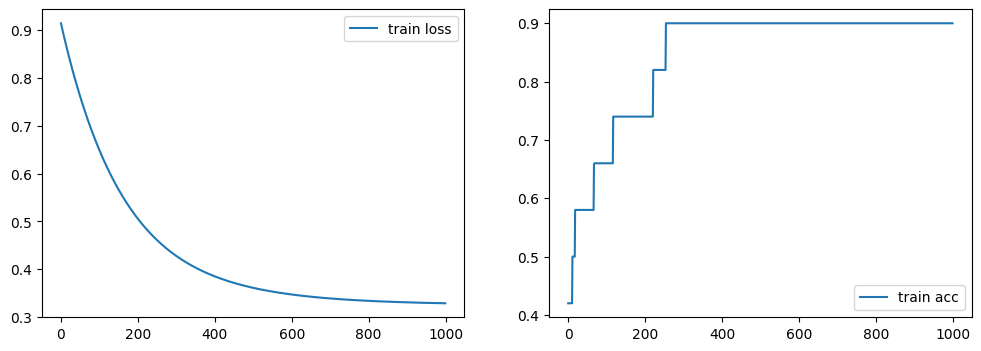

In [240]:
input = 7
hidden = 3
output = 10
dataset_size = 80

training_matrice_hu = read_csv_files("training_moment_hu.csv")
np.random.shuffle(training_matrice_hu)

Xi_hu = training_matrice_hu[ : , 1 : 8].T
Sk_hu = calc_Sk_hu(training_matrice_hu, 80, 10).T

parametres_hu = reseaux_neurones(Xi_hu, Sk_hu, hidden, taux_dapprentissage=0.01, n_iter=1000)

##### TR - TE

In [241]:
print("moment de Hu : ")

X_test_hu = read_csv_files("test_moment_hu.csv")[:, 1: 8].T
y_test_hu = read_csv_files("test_moment_hu.csv")[:, 8:].T

y_pred_hu = []
for i in range(20):
    y_pred = propagation(X_test_hu[:, i].reshape((7, 1)), parametres_hu)['A2']
    temp = y_pred[0]
    max = 0
    for j in range(1, 10):
        if temp < y_pred[j]:
            temp = y_pred[j]
            max = j

    y_pred_hu.append(max)

classification_hu = y_pred_hu == y_test_hu[0, :]
taux_classification_hu = 0

for i in classification_hu:
    if i:
        taux_classification_hu += 1

taux_classification_hu *= ((1 / y_test_hu.shape[1]) * 100)
taux_erreur_hu = 100 - taux_classification_hu

print("Taux de classification :", taux_classification_hu, "%")
print("Taux d'erreur : ", taux_erreur_hu, "%")

moment de Hu : 
Taux de classification : 10.0 %
Taux d'erreur :  90.0 %


##### Réseaux de neurones - Moment de Tchebichef 

In [139]:
def calc_Sk_tchebichef(training_matrice, dataset_size, output):
    data = training_matrice[:, 11:].T
    sk = np.zeros([dataset_size, output], dtype=np.float64)
    
    temp = 0
    for i in range(dataset_size):
        sk[i, int(data[0, temp])] = 1
        temp += 1

    return sk

##### L'apprentissage

100%|██████████| 1000/1000 [00:05<00:00, 170.83it/s]


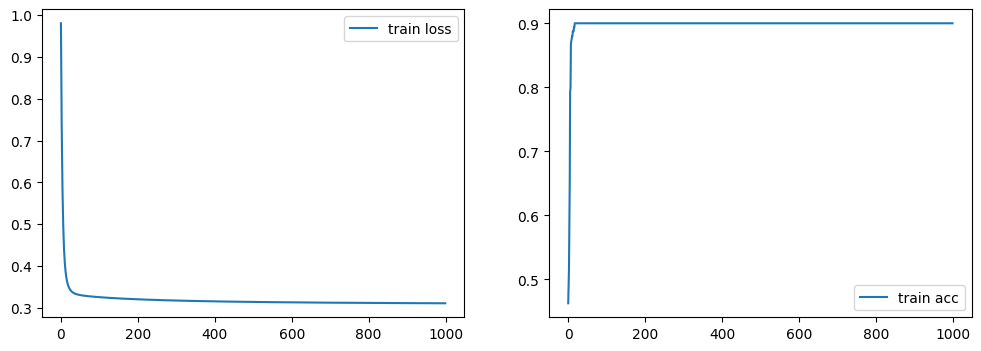

In [233]:
input = 10
hidden = 3
output = 10

dataset_size = 80

training_matrice_tchebichef  = read_csv_files("training_moment_tchebichef.csv")
np.random.shuffle(temp)

Xi_tchebichef = training_matrice_tchebichef[ : , 1 : 11].T
Sk_tchebichef = calc_Sk_tchebichef(training_matrice_tchebichef, 80, 10).T

parametres_tchebichef = reseaux_neurones(Xi_tchebichef, Sk_tchebichef, hidden, taux_dapprentissage=0.3, n_iter=1000)

##### TR - TE

In [234]:
print("moment de Tchebichef : ")

X_test_tchebichef = read_csv_files("test_moment_tchebichef.csv")[:, 1: 11].T
y_test_tchebichef = read_csv_files("test_moment_tchebichef.csv")[:, 11:].T

y_pred_tchebichef = []
for i in range(20):
    y_pred = propagation(X_test_tchebichef[:, i].reshape((10, 1)), parametres_tchebichef)['A2']
    temp = y_pred[0]
    max = 0
    for j in range(1, 10):
        if temp < y_pred[j]:
            temp = y_pred[j]
            max = j

    y_pred_tchebichef.append(max)

classification_tchebichef = y_pred_tchebichef == y_test_tchebichef[0, :]
taux_classification_tchebichef = 0

for i in classification_tchebichef:
    if i:
        taux_classification_tchebichef += 1

taux_classification_tchebichef *= ((1 / y_test_tchebichef.shape[1]) * 100)
taux_erreur_tchebichef = 100 - taux_classification_tchebichef

print("Taux de classification :", taux_classification_tchebichef, "%")
print("Taux d'erreur : ", taux_erreur_tchebichef, "%")

moment de Tchebichef : 
Taux de classification : 10.0 %
Taux d'erreur :  90.0 %


#### Réseaux de neurones - Scikit-Learn

##### Dataset

In [ ]:
# Moment de Hu
csv_files_maker(dataset, 10, 10, 1, moment_hu)

# Moment de Tchebichef
csv_files_maker(dataset, 10, 10, 1, moment_tchebichef)

##### Algorithme

In [312]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [313]:
# Moment de Hu
print("Moment de Hu : ")

X_hu = read_csv_files("training_moment_hu.csv")

y_hu = X_hu[:, X_hu.shape[1] - 1]
X_hu = X_hu[:, 1 : X_hu.shape[1] -1]

X_hu_train, X_hu_test, y_hu_train, y_hu_test = train_test_split(X_hu, y_hu, test_size=0.2)

scaler1 = StandardScaler()
scaler1.fit(X_hu_train)
X_hu_train = scaler1.transform(X_hu_train)
X_hu_test = scaler1.transform(X_hu_test)

rn1 = MLPClassifier(activation='logistic', solver='sgd', hidden_layer_sizes=(
    3,), random_state=1, max_iter=1000, learning_rate_init=0.9)
rn1.fit(X_hu_train, y_hu_train)

y_hu_pred = rn1.predict(X_hu_test)


classification_hu = y_hu_pred == y_hu_test
taux_classification_hu = 0

for i in classification_hu:
    if i:
        taux_classification_hu += 1

taux_classification_hu *= ((1 / y_hu_test.shape[0]) * 100)
taux_erreur_hu = 100 - taux_classification_hu

print("Taux de classification :", taux_classification_hu, "%")
print("Taux d'erreur : ", taux_erreur_hu, "%")  


# Moment de Tchebichef
print("Moment de Tchebichef : ")

X_tchebichef = read_csv_files("training_moment_tchebichef.csv")

y_tchebichef = X_tchebichef[:, X_tchebichef.shape[1] - 1]
X_tchebichef = X_tchebichef[:, 1 : X_tchebichef.shape[1] -1]

X_tchebichef_train, X_tchebichef_test, y_tchebichef_train, y_tchebichef_test = train_test_split(X_tchebichef, y_tchebichef, test_size=0.2)

scaler2 = StandardScaler()
scaler2.fit(X_tchebichef_train)
X_tchebichef_train = scaler2.transform(X_tchebichef_train)
X_tchebichef_test = scaler2.transform(X_tchebichef_test)

rn2 = MLPClassifier(activation='logistic', solver='sgd', hidden_layer_sizes=(
    3,), random_state=1, max_iter=1000, learning_rate_init=0.9)
rn2.fit(X_tchebichef_train, y_tchebichef_train)

y_tchebichef_pred = rn2.predict(X_tchebichef_test)

classification_tchebichef = y_tchebichef_pred == y_tchebichef_test
taux_classification_tchebichef = 0

for i in classification_tchebichef:
    if i:
        taux_classification_tchebichef += 1

taux_classification_tchebichef *= ((1 / y_tchebichef_test.shape[0]) * 100)
taux_erreur_tchebichef = 100 - taux_classification_tchebichef

print("Taux de classification :", taux_classification_tchebichef, "%")
print("Taux d'erreur : ", taux_erreur_tchebichef, "%")  

Moment de Hu : 
Taux de classification : 35.0 %
Taux d'erreur :  65.0 %
Moment de Tchebichef : 
Taux de classification : 20.0 %
Taux d'erreur :  80.0 %
